### Please install the required Python modules/SDKs

In [1]:
! activate ai-azure-c1

import sys

sys.path.append("/opt/conda/envs/ai-azure-c1/lib/python3.8/site-packages")

Could not find conda environment: ai-azure-c1
You can list all discoverable environments with `conda info --envs`.



# Azure Custom Vision - Object Detection Demo

## Import utility functions and Python modules 

In [2]:
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os, time, uuid

In [3]:
def show_image_in_cell(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()

In [4]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials


### Resources:
- Azure Custom Vision Endpoint
- Training Reource ID and Key
- Prediction Resource ID and Key

## Make sure you have the correct Training and Prediction Endpoints, Keys and Resource IDs separately

### Your Training Endpoint resource must be for both training and prediction for this demo

In [5]:
TRAINING_ENDPOINT = "https://nayanacustomvision.cognitiveservices.azure.com/"
training_key = "ce08598caf404621b37136119dccd921"
training_resource_id = '/subscriptions/bb272072-9c6d-4e28-b814-947814c3e6ef/resourceGroups/nayana-ai-msft-azure/providers/Microsoft.CognitiveServices/accounts/nayanacustomvision'

In [6]:
PREDICTION_ENDPOINT = 'https://nayanacustomvision-prediction.cognitiveservices.azure.com/'
prediction_key = "6b7c1fe2bea0431a8a3b4259749591e6"
prediction_resource_id = "/subscriptions/bb272072-9c6d-4e28-b814-947814c3e6ef/resourceGroups/nayana-ai-msft-azure/providers/Microsoft.CognitiveServices/accounts/nayanacustomvision-Prediction"

## Instantiate and authenticate the training client with endpoint and key 

In [7]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(TRAINING_ENDPOINT, training_credentials)

In [8]:
trainer.api_version

'3.4-preview'

## Instantiate and authenticate the prediction client with endpoint and key

In [9]:
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(PREDICTION_ENDPOINT, prediction_credentials)

In [10]:
predictor.api_version

'3.1'

## Creating Training Project First

In [11]:
# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Create a new project
print ("Your Object Detection Training project has been created. Please move on.")
project_name = uuid.uuid4()
project = trainer.create_project(project_name, domain_id=obj_detection_domain.id)
#project_id = "0b414ef1-90ac-4d5e-8653-20dca7286b7f"

Your Object Detection Training project has been created. Please move on.


## Getting Project Details as collective information 

In [12]:
project.as_dict()

{'id': 'c4c324e8-4f9e-49e3-b4be-797b38a686de',
 'name': 'cfd70f0c-a407-4410-b6ab-bc0632cd547e',
 'description': '',
 'settings': {'domain_id': 'da2e3a8a-40a5-4171-82f4-58522f70fbc1',
  'classification_type': 'Multilabel',
  'target_export_platforms': [],
  'use_negative_set': True,
  'image_processing_settings': {'augmentation_methods': {'rotation': True,
    'scaling': True,
    'translation': True,
    'horizontal flip': True,
    'equalize': True,
    'solarize': True,
    'padtosquare': True}}},
 'created': '2022-06-21T10:12:40.683Z',
 'last_modified': '2022-06-21T10:12:40.683Z',
 'dr_mode_enabled': False,
 'status': 'Succeeded'}

In [13]:
project.status

'Succeeded'

## Adding Tags based on training requirements
- We have 2 tags in the training process 
  - Bird
  - Flower

In [14]:
bird_tag = trainer.create_tag(project.id, "Bird")

In [15]:
flower_tag = trainer.create_tag(project.id, "Flower")

# VERY IMPORTANT - PAUSE HERE
# Now, please go to the Custom Vision portal, upload and label your training images
## Please read the following instructions:

- The training images used in this demo can be found here: https://github.com/udacity/cd0461-building-computer-vision-solutions-with-azure-exercises/tree/main/resources/bird-flower
- Please download these images from the GitHub repo
- Please visit the Custom Vision Portal (https://computervision.api) and upload all of these images manually. 
- After that, you can label the tag region for each object directly at the portal. 
- This way, you don't need to use any third-party website or service to generate tag regions in the form of bounding box coordinates. If you have training images with those coordinates, you can use the optional section below to upload your images with the tagged objects via code.
- Once you have uploaded and labeled all the training images at the portal, you can come back to this notebook and start the training process. 

### =====================================================

## You can skip this section (between dotted lines) if you are uploading and labeling images manually at the portal.

## Optional: Uploading image with bounding box coordinates and tag via code



* If you have added bounding boxes and tags to every object to your images, you can upload these images with the tag regions via code.

* This is an alternative to uploading and labeling images directly at the Custom Vision portal. 

* Here is an example image from the URL: https://raw.githubusercontent.com/udacity/cd0461-building-computer-vision-solutions-with-azure-exercises/main/resources/image-01-boundingbox.png

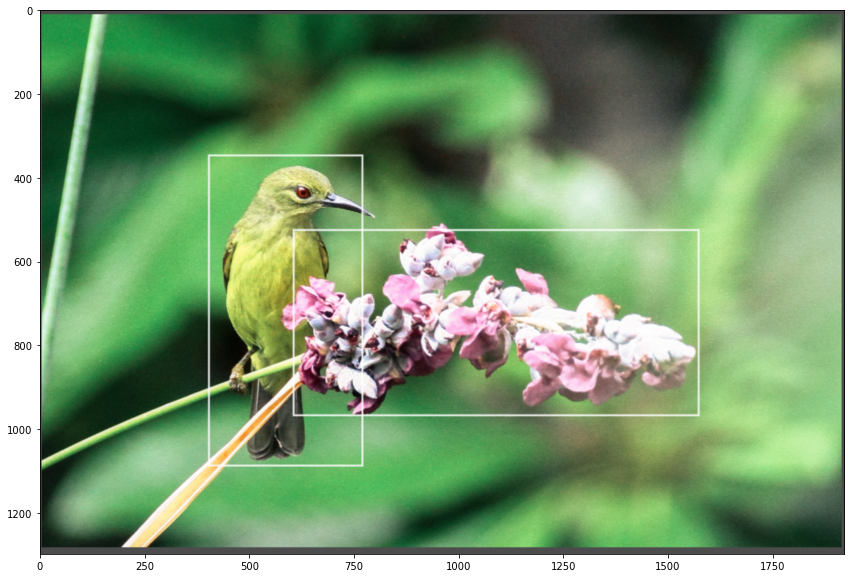

In [16]:
img_url = 'https://raw.githubusercontent.com/udacity/cd0461-building-computer-vision-solutions-with-azure-exercises/main/resources/image-01-boundingbox.png'
show_image_in_cell(img_url)

### Step #1: Create the bounding box coordinates for every tag on your images

* Make sure to add your folder full path and correct folder name of where all training images are located.

In [17]:
local_image_path = 'test-flower-bird-img'

In [18]:
!ls $local_image_path

image-01-boundingbox.png                od-image-03.jpeg
image-01-labeled-data-upload-verify.png od-image-04.jpeg
od-image-02.jpeg                        od-test-01.jpeg


In [19]:
# "image_01.jpg" is the same image as the one shown above

flower_image_regions = {"image-01-boundingbox": [ 0.314344746162928, 0.405046480743692, 0.506493506493506, 0.34705621956618 ]}
bird_image_regions = {"image-01-boundingbox": [ 0.208677685950413, 0.265161575918548, 0.19185360094451, 0.581673306772908 ]}

### Step #2: Upload image with tag regions to the Custom Vision portal 

In [20]:
tagged_images_with_regions = []

for file_name in flower_image_regions.keys():
    x,y,w,h = flower_image_regions[file_name]
    regions = [ Region(tag_id=flower_tag.id, left=x,top=y,width=w,height=h) ]
  
    with open(os.path.join (local_image_path, file_name + ".png"), mode="rb") as image_contents:
        tagged_images_with_regions.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), regions=regions))

for file_name in bird_image_regions.keys():
    x,y,w,h = bird_image_regions[file_name]
    regions = [ Region(tag_id=bird_tag.id, left=x,top=y,width=w,height=h) ]
  
    with open(os.path.join (local_image_path, file_name + ".png"), mode="rb") as image_contents:
        tagged_images_with_regions.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), regions=regions))

        
training_upload_result = trainer.create_images_from_files(project.id, ImageFileCreateBatch(images=tagged_images_with_regions))
if not training_upload_result.is_batch_successful:
    for image in training_upload_result.images:
        print("Image status: ", image.status)
    exit(-1)

Image status:  OKDuplicate
Image status:  OK


### Step #3: Validate the image upload at the Custom Vision portal to make sure image uploading is done correctly with the coordinates

In [21]:
training_upload_result.is_batch_successful

False

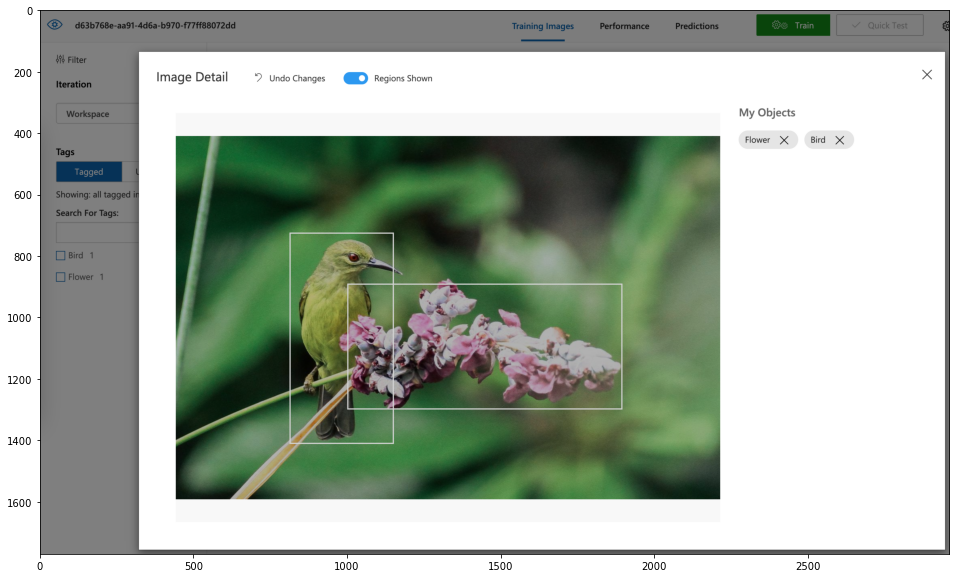

In [22]:
# If the image with tag regions is uploaded successfully,
# you should see the image on the Custom Vision portal 
# with the proper tags and bounding boxes.

show_image_in_cell('https://raw.githubusercontent.com/udacity/cd0461-building-computer-vision-solutions-with-azure-exercises/main/resources/image-01-labeled-data-upload-verify.png')

### This is the end of the optional section.  
### =====================================================

## Once you have uploaded and labeled all the training images at the portal, you can start the training process with the code below.

## Start Object Detection Training
- We will be keep checking every 10 seconds the training progress

In [25]:
#iteration_id = "ef20cdc8-63cb-40b0-ac85-7878e3e94bcc"

iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    print ("Waiting 10 seconds...")
    time.sleep(10)

Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 sec

## After training is complete, we will check model performance

In [26]:
iteration.as_dict()

{'id': '31106c08-c783-42e1-a43a-fb99e3b74928',
 'name': 'Iteration 1',
 'status': 'Completed',
 'created': '2022-06-21T10:12:40.683Z',
 'last_modified': '2022-06-21T10:37:55.248Z',
 'trained_at': '2022-06-21T10:37:55.243Z',
 'project_id': 'c4c324e8-4f9e-49e3-b4be-797b38a686de',
 'exportable': False,
 'domain_id': 'da2e3a8a-40a5-4171-82f4-58522f70fbc1',
 'training_type': 'Regular',
 'reserved_budget_in_hours': 0,
 'training_time_in_minutes': 2}

In [27]:
iteration_list = trainer.get_iterations(project.id)
for iteration_item in iteration_list:
    print(iteration_item)

{'additional_properties': {}, 'id': '31106c08-c783-42e1-a43a-fb99e3b74928', 'name': 'Iteration 1', 'status': 'Completed', 'created': datetime.datetime(2022, 6, 21, 10, 12, 40, 683000, tzinfo=<isodate.tzinfo.Utc object at 0x7fa6d4dcd670>), 'last_modified': datetime.datetime(2022, 6, 21, 10, 37, 55, 248000, tzinfo=<isodate.tzinfo.Utc object at 0x7fa6d4dcd670>), 'trained_at': datetime.datetime(2022, 6, 21, 10, 37, 55, 243000, tzinfo=<isodate.tzinfo.Utc object at 0x7fa6d4dcd670>), 'project_id': 'c4c324e8-4f9e-49e3-b4be-797b38a686de', 'exportable': False, 'exportable_to': None, 'domain_id': 'da2e3a8a-40a5-4171-82f4-58522f70fbc1', 'classification_type': None, 'training_type': 'Regular', 'reserved_budget_in_hours': 0, 'training_time_in_minutes': 2, 'publish_name': None, 'original_publish_resource_id': None, 'custom_base_model_info': None, 'training_error_details': None}


In [28]:
model_perf = trainer.get_iteration_performance(project.id, iteration_list[0].id)

In [29]:
model_perf.as_dict()

{'per_tag_performance': [{'id': 'b651c49e-5f96-4830-af6d-d3fedc928ee4',
   'name': 'Flower',
   'precision': 0.0,
   'precision_std_deviation': 0.0,
   'recall': 0.0,
   'recall_std_deviation': 0.0,
   'average_precision': 0.43846154},
  {'id': '88b215b8-e5ae-4f6e-8a06-f60b36be2191',
   'name': 'Bird',
   'precision': 1.0,
   'precision_std_deviation': 0.0,
   'recall': 0.11764706,
   'recall_std_deviation': 0.0,
   'average_precision': 0.4017473}],
 'precision': 1.0,
 'precision_std_deviation': 0.0,
 'recall': 0.074074075,
 'recall_std_deviation': 0.0,
 'average_precision': 0.4201044}

## Publishing the Model to the Project Endpoint

In [30]:
## Setting the Iteration Name, this will be used when Model training is completed
publish_iteration_name = "udacity-2-classes-object-detection-custom"

In [31]:
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)
print ("Done!")

Done!


## Performing Prediction
- Using the predictor object 

In [32]:
local_image_path = 'test-flower-bird-img'

In [33]:
!ls $local_image_path

image-01-boundingbox.png                od-image-03.jpeg
image-01-labeled-data-upload-verify.png od-image-04.jpeg
od-image-02.jpeg                        od-test-01.jpeg


In [34]:
def perform_prediction(image_file_name):
    with open(os.path.join (local_image_path,  image_file_name), "rb") as image_contents:
        results = predictor.detect_image(project.id, publish_iteration_name, image_contents.read())
        # Display the results.
        for prediction in results.predictions:
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))

In [35]:
# file_name = "ENTER LOCAL TEST IMAGE FILE NAME HERE"
# You can upload a test image and replace "flower.jpg" with the name of your own image

file_name = "od-test-01.jpeg"

In [36]:
perform_prediction(file_name)

	Bird: 80.32%
	Flower: 73.29%
	Flower: 56.95%
	Flower: 47.61%
	Flower: 26.77%
	Flower: 25.68%
	Flower: 6.67%
	Flower: 5.26%
	Flower: 4.35%
	Flower: 3.16%
	Flower: 2.89%
	Flower: 2.77%
	Flower: 2.77%
	Flower: 2.42%
	Flower: 2.42%
	Flower: 2.38%
	Flower: 2.00%
	Flower: 1.90%
	Flower: 1.89%
	Flower: 1.71%
	Flower: 1.64%
	Flower: 1.54%
	Flower: 1.49%
	Flower: 1.45%
	Flower: 1.35%
	Flower: 1.34%
	Flower: 1.33%
	Flower: 1.22%
	Flower: 1.20%
	Flower: 1.05%
	Flower: 1.03%
	Flower: 1.01%
	Flower: 0.95%
	Flower: 0.95%
	Flower: 0.92%
	Flower: 0.91%
	Flower: 0.90%
	Flower: 0.90%
	Flower: 0.89%
	Flower: 0.88%
	Flower: 0.87%
	Flower: 0.77%
	Flower: 0.76%
	Flower: 0.76%
	Flower: 0.74%
	Bird: 0.73%
	Flower: 0.70%
	Flower: 0.68%
	Flower: 0.68%
	Flower: 0.67%
	Flower: 0.65%
	Flower: 0.65%
	Flower: 0.64%
	Flower: 0.64%
	Flower: 0.60%
	Flower: 0.59%
	Flower: 0.59%
	Flower: 0.58%
	Flower: 0.58%
	Flower: 0.56%
	Flower: 0.56%
	Flower: 0.55%
	Flower: 0.55%
	Flower: 0.54%
	Flower: 0.54%
	Flower: 0.53%
	Flower:

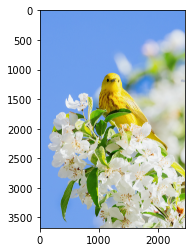

In [37]:
## Checking the Image
with open(os.path.join (local_image_path, file_name), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

In [38]:
# file_name_2 = "ENTER LOCAL TEST IMAGE FILE NAME HERE"
# You can upload a test image and replace "bird.jpg" with the name of your own image

file_name_2 = "od-image-02.jpeg"

In [39]:
perform_prediction(file_name_2)

	Bird: 88.55%
	Bird: 64.12%
	Flower: 54.28%
	Flower: 21.14%
	Flower: 11.03%
	Flower: 9.77%
	Flower: 3.14%
	Flower: 1.91%
	Flower: 1.66%
	Flower: 1.34%
	Bird: 1.34%
	Flower: 1.18%
	Flower: 1.16%
	Bird: 1.06%
	Flower: 1.05%
	Flower: 0.81%
	Flower: 0.81%
	Flower: 0.80%
	Flower: 0.79%
	Flower: 0.74%
	Flower: 0.74%
	Flower: 0.71%
	Flower: 0.70%
	Flower: 0.68%
	Flower: 0.68%
	Flower: 0.68%
	Flower: 0.66%
	Flower: 0.66%
	Flower: 0.64%
	Bird: 0.63%
	Flower: 0.62%
	Flower: 0.61%
	Flower: 0.61%
	Flower: 0.60%
	Bird: 0.59%
	Flower: 0.58%
	Flower: 0.58%
	Flower: 0.57%
	Flower: 0.56%
	Flower: 0.55%
	Flower: 0.55%
	Flower: 0.53%
	Flower: 0.53%
	Flower: 0.53%
	Bird: 0.52%
	Flower: 0.52%
	Flower: 0.52%
	Flower: 0.51%
	Flower: 0.51%
	Flower: 0.51%


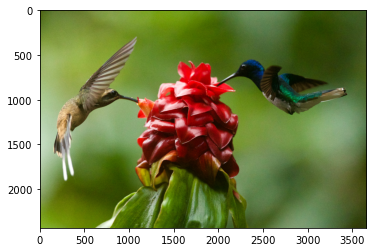

In [40]:
## Checking the Image
with open(os.path.join (local_image_path, file_name_2), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)